<small><i>This notebook was created by [Alexander Fridman](http://www.rocketscience.ai) for the Lecture Course. Source and license info is on [GitHub](https://github.com/volhahedranovich/jupyter_lectures).</i></small>

### In this example where used following libraries of latest versions:
1. keras
1. scikit-learn
1. numpy
1. pandas

In [19]:
import os
import pickle
import random
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import SVG
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Embedding, Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


%matplotlib inline

# Prepare a dataset

In [2]:
N_CLASSES = 5
DATASET_PATH = 'data'

In [3]:
assert N_CLASSES < 20

# load dataset
data = fetch_20newsgroups(subset='all')

# select N_CLASSES at random
selected_target_names = set(random.sample(data['target_names'], N_CLASSES))

# found positions of items of selected classes
indexes = [i for i, y_i in enumerate(data['target']) 
           if data['target_names'][y_i] in selected_target_names]
texts = [data['data'][i] for i in indexes]
targets = [data['target_names'][data['target'][i]] for i in indexes]

print('#texts:', len(texts))
print('Selected classes:')
print('\n'.join(map(str, Counter(targets).most_common())))

# save dataset
!rm -rf {DATASET_PATH}
!mkdir {DATASET_PATH}

# create separate folder for each class
for target_name in selected_target_names:
    !mkdir {DATASET_PATH}/{target_name}
    
for i, (target, text) in enumerate(sorted(zip(targets, texts))):
    path = os.path.join(DATASET_PATH, target, '{}.txt'.format(i))
    
    with open(path, 'w+') as f:
        f.write(text)

#texts: 4369
Selected classes:
('soc.religion.christian', 997)
('sci.space', 987)
('comp.sys.ibm.pc.hardware', 982)
('talk.politics.misc', 775)
('talk.religion.misc', 628)


# Load, split, analyze dataset

In [27]:
def load_data(path, remove_label=False):
    """
    data loading function
    
    assumes there is a folder full of *.txt files for each class
    """
    texts, targets = [], []
    
    for target in os.listdir(path):
        target_path = os.path.join(path, target)
        
        for text_file_name in os.listdir(target_path):
            text_file_path = os.path.join(target_path, text_file_name)
            
            targets.append(target)
            with open(text_file_path) as f:
                text = f.read()
                if remove_label:
                    text = '.'.join(text.split('.')[1:])
                texts.append(text)
                
    return texts, targets

## call as load_data(DATASET_PATH, remove_label=True) if needed

In [5]:
texts, targets = load_data(DATASET_PATH)
N_CLASSES = len(np.unique(targets))

print('Dataset loaded:')
print('\n'.join(map(str, Counter(targets).most_common())))

Dataset loaded:
('soc.religion.christian', 997)
('sci.space', 987)
('comp.sys.ibm.pc.hardware', 982)
('talk.politics.misc', 775)
('talk.religion.misc', 628)


### Split dataset into train, test, valid

In [6]:
train_texts, test_texts, train_targets, test_targets = train_test_split(texts,
                                                                        targets,
                                                                        test_size=0.2,
                                                                        stratify=targets,
                                                                        random_state=42)
train_texts, valid_texts, train_targets, valid_targets = train_test_split(train_texts,
                                                                          train_targets,
                                                                          test_size=0.2,
                                                                          stratify=train_targets,
                                                                          random_state=42)

### Encode targets

    also convert targets to 1-hot format required by using categorical_crossentropy loss 

In [7]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(train_targets)
y_valid = label_encoder.transform(valid_targets)
y_test = label_encoder.transform(test_targets)

y_train_1_hot = to_categorical(y_train, N_CLASSES)
y_valid_1_hot = to_categorical(y_valid, N_CLASSES)

with open('label_encoder.p', 'wb') as f:
    pickle.dump(label_encoder, f)

### Tokenize and encode text

In [8]:
NUM_WORDS = 20000

tokenizer = Tokenizer(NUM_WORDS)
tokenizer.fit_on_texts(train_texts)
NUM_WORDS = min(NUM_WORDS, len(tokenizer.word_index))
print('Actual NUM_WORDS={}'.format(NUM_WORDS))

with open('tokenizer.p', 'wb') as f:
    pickle.dump(tokenizer, f)

Actual NUM_WORDS=20000


In [9]:
train_texts_encoded = tokenizer.texts_to_sequences(train_texts)
valid_texts_encoded = tokenizer.texts_to_sequences(valid_texts)
test_texts_encoded = tokenizer.texts_to_sequences(test_texts)

### Analise train text lengths and choose MAX_SEQUENCE_LENGTH

In [10]:
train_text_lengths = list(map(len, train_texts_encoded))
pd.Series(train_text_lengths).describe()

count    2796.000000
mean      331.563305
std       518.084658
min        19.000000
25%       128.000000
50%       204.000000
75%       344.000000
max      8396.000000
dtype: float64

In [13]:
MAX_SEQUENCE_LENGTH = 300

In [14]:
X_train = pad_sequences(train_texts_encoded, MAX_SEQUENCE_LENGTH)
X_valid = pad_sequences(valid_texts_encoded, MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(test_texts_encoded, MAX_SEQUENCE_LENGTH)

# Set up and train network

   
Feel free to modify network, for example:
1. initialize an embedding layer with glove weights
2. add dropout to dense layers or even recurrent connections
3. try convolutions and recurrent blocks together (more information by [this](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/) link)
    
## NOTE:
Size of the last dense layer is equal to the number of classes

15689 words found in glove
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 300, 100)          2000100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 2,117,993
Trainable params: 117,893
Non-trainable params: 2,000,100
_________________________________________________________________
None


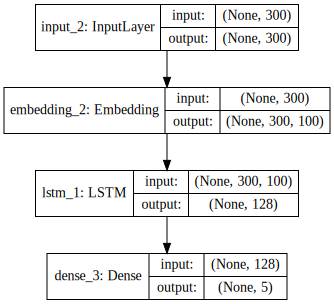

In [16]:
def load_glove_weights_matrix(word_index, embedding_dim=100, glove_dir='glove'):
    weights_matrix = np.zeros((len(word_index) + 1, embedding_dim), dtype=np.float32)
    glove_path = os.path.join(glove_dir, 'glove.twitter.27B.{}d.txt'.format(embedding_dim))
    
    n_words_found = 0
    with open(glove_path) as f:
        for line in f:
            word, *weights = line.strip().split()
            
            if word in word_index:
                weights_matrix[word_index[word]] = np.array(list(map(float, weights)))
                n_words_found += 1
                
    print('{} words found in glove'.format(n_words_found))
    return weights_matrix


def extract_word_index_from_tokenizer(tokenizer):
    return {w: i for w, i in tokenizer.word_index.items() if i <= tokenizer.num_words}

    
def build_cnn_model_with_glove_embeddings(embedding_weights):
    embedding_dim = embedding_weights.shape[1]
    
    embedding_layer = Embedding(
        NUM_WORDS + 1,
        embedding_dim,
        weights=[embedding_weights],
        input_length=MAX_SEQUENCE_LENGTH, 
        trainable=False)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(128, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(N_CLASSES, activation='softmax')(x)

    return Model(sequence_input, preds)


def build_rnn_model(embedding_weights, rnn_size=128):
    embedding_dim = embedding_weights.shape[1]
    
    embedding_layer = Embedding(
        NUM_WORDS + 1,
        embedding_dim,
        weights=[embedding_weights],
        input_length=MAX_SEQUENCE_LENGTH,
        mask_zero=True, 
        trainable=False)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = LSTM(rnn_size)(embedded_sequences)
    preds = Dense(N_CLASSES, activation='softmax')(x)

    return Model(sequence_input, preds)
    
    
word_index = extract_word_index_from_tokenizer(tokenizer)
embedding_weights = load_glove_weights_matrix(word_index)
model = build_rnn_model(embedding_weights)

model.compile('adam', 'categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# IMPORTANT NOTE
    to save model we will use here ModelCheckpoint which saves our model after each epoch (by default)
    also model can be saved directly by calling save method on a model instance
    
```python
    model.save('model.hdf5')
```

In [17]:
# prepare directory for checkpoints
!rm -rf checkpoints
!mkdir checkpoints

checkpointer = ModelCheckpoint('checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5')
stopper = EarlyStopping()

history = model.fit(X_train, y_train_1_hot,
                    batch_size=32,
                    validation_data=[X_valid, y_valid_1_hot],
                    callbacks=[checkpointer, stopper],
                    epochs=10)

Train on 2796 samples, validate on 699 samples
Epoch 1/10
2796/2796 [==============================] - 32s 12ms/step - loss: 1.3304 - categorical_accuracy: 0.4338 - val_loss: 1.0864 - val_categorical_accuracy: 0.5536
Epoch 2/10
2796/2796 [==============================] - 32s 11ms/step - loss: 0.9491 - categorical_accuracy: 0.6191 - val_loss: 1.5590 - val_categorical_accuracy: 0.4979
Epoch 3/10
2796/2796 [==============================] - 32s 12ms/step - loss: 1.0773 - categorical_accuracy: 0.5937 - val_loss: 1.0251 - val_categorical_accuracy: 0.6080
Epoch 4/10
2796/2796 [==============================] - 32s 12ms/step - loss: 1.0410 - categorical_accuracy: 0.5869 - val_loss: 1.0689 - val_categorical_accuracy: 0.5651
Epoch 5/10
2796/2796 [==============================] - 32s 11ms/step - loss: 0.8725 - categorical_accuracy: 0.6627 - val_loss: 0.8103 - val_categorical_accuracy: 0.7010
Epoch 6/10
2796/2796 [==============================] - 33s 12ms/step - loss: 0.8591 - categorical_accu

### Visualize learning curves and select the best checkpoint

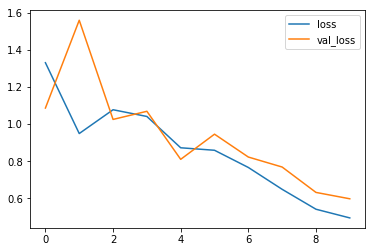

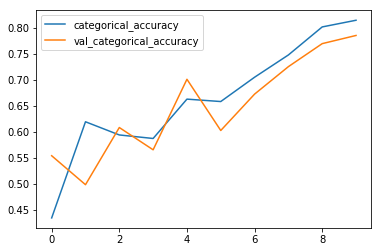

In [18]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

    from learning curves plotted above we can conclude that our model reached best performance after 2nd epoch and then overfitted.

### Load 10th checkpoint and measure quality on test set

In [73]:
model = load_model('checkpoints/weights.02-0.44.hdf5')

In [74]:
y_test_pred_proba = model.predict(X_test, batch_size=256, verbose=1)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

964/964 [==============================] - 0s 241us/step


In [75]:
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

                       precision    recall  f1-score   support

            rec.autos       0.88      0.69      0.77       198
   rec.sport.baseball       0.79      0.95      0.87       199
      sci.electronics       0.83      0.80      0.81       197
   talk.politics.guns       0.76      0.83      0.79       182
talk.politics.mideast       0.90      0.87      0.88       188

          avg / total       0.83      0.83      0.83       964



# Load model and run inference on "new" data

In [76]:
# load our pipeline (only tokenzer in our case)
with open('tokenizer.p', 'rb') as f:
    tokenizer = pickle.load(f)
    
# load label encoder (required to restore targets from model predictions)
with open('label_encoder.p', 'rb') as f:
    label_encoder = pickle.load(f)
    
# load model
model = model = load_model('checkpoints/weights.02-0.44.hdf5')
    
# let's imagine our "new" data is a set of *.txt files in NEW_DATA_PATH dir
NEW_DATA_PATH = 'data/rec.autos'
new_texts = [open(os.path.join(NEW_DATA_PATH, file_name)).read() 
             for file_name in os.listdir(NEW_DATA_PATH)]

new_texts_encoded = tokenizer.texts_to_sequences(new_texts)
X_new = pad_sequences(new_texts_encoded, MAX_SEQUENCE_LENGTH)

# run prediction on our new data (we will get a vector of class probabilities for each text)
y_new_pred_proba = model.predict(X_new, batch_size=256, verbose=1)
# select most probable class for each text
y_new_pred = np.argmax(y_new_pred_proba, axis=1)
# restore target names
y_new_targets = label_encoder.inverse_transform(y_new_pred)

990/990 [==============================] - 0s 212us/step


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [77]:
Counter(y_new_targets)

Counter({'rec.autos': 743,
         'rec.sport.baseball': 78,
         'sci.electronics': 109,
         'talk.politics.guns': 56,
         'talk.politics.mideast': 4})

In [24]:
def predict_on_text(model, label_encoder, tokenizer, text, n_top_labels):
    text = [text]
    text_encoded = tokenizer.texts_to_sequences(text)
    X = pad_sequences(text_encoded, MAX_SEQUENCE_LENGTH)
    y_pred_proba = model.predict(X)[0]
    
    top_n_label_idxs = y_pred_proba.argsort()[::-1][:n_top_labels]
    top_n_probs = y_pred_proba[top_n_label_idxs]
    top_n_labels = label_encoder.inverse_transform(top_n_label_idxs)
    
    return list(zip(top_n_labels, top_n_probs))

In [26]:
text = "hardware pc processor and a bit of deep space"
n_labels = 3

predict_on_text(model, label_encoder, tokenizer, text, n_labels)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[('comp.sys.ibm.pc.hardware', 0.85800827),
 ('sci.space', 0.13086149),
 ('talk.politics.misc', 0.0055755093)]